In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-07-26 10:46:23.338799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 10:46:23.370279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:46:23.397902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:46:23.398053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6751100967377330417
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5782765568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16336889694616415019
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
x_train_pred_phi = np.load("data/tips/x_train_pred_phi.npy")
x_val_pred_phi = np.load("data/tips/x_val_pred_phi.npy")
y_train_phi = np.load("data/tips/y_train_phi.npy")
y_train_tips = np.load("data/tips/y_train_tips.npy")
y_val_phi = np.load("data/tips/y_val_phi.npy")
y_val_tips = np.load("data/tips/y_val_tips.npy")

print("Training Dataset Shapes: " + str(x_train_pred_phi.shape) + ", Target Tips Shape:" + str(y_train_tips.shape) + ", Target Phi Shapes:" + str(y_train_phi.shape))

Training Dataset Shapes: (4352, 100, 100, 2), Target Tips Shape:(4352, 100, 100, 1), Target Phi Shapes:(4352, 100, 100, 1)


Rand case: 1672


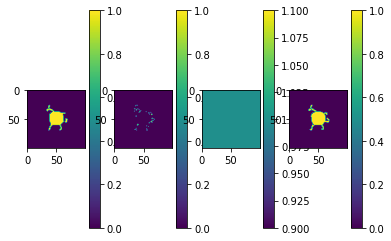

In [8]:
rand_case = np.random.randint((len(x_train_pred_phi)))
print(f"Rand case: {rand_case}")
plt.subplot(1,4,1)
plt.imshow(x_train_pred_phi[rand_case,...,0])
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(y_train_tips[rand_case,...])
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(x_train_pred_phi[rand_case,...,1])
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(y_train_phi[rand_case,...])
plt.colorbar()
plt.show()

In [3]:
from tensorflow.keras import layers

inp = layers.Input(shape=(x_train_pred_phi.shape[1:]))

x0 = layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (1, 1),
    padding="valid",
    activation="relu",
)(inp)
x0 = layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=None, 
    padding="valid"
)(x0)
x1 = layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (1, 1),
    padding="valid",
    activation="relu",
)(x0)
x1 = layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=None, 
    padding="valid"
)(x1)

x2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(x1)
x3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
)(x2)

2022-07-26 10:46:24.070053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:46:24.070223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:46:24.070326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:46:24.070552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:46:24.070661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
model = keras.models.Model(inp, x3)
model.compile(
    loss=keras.losses.binary_crossentropy, 
    # loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4))
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        3264      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 48, 48, 64)       294976

In [5]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/tipsCNN_predBased')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
    epochs = 1000
    batch_size = 64
    with tf.device('/device:GPU:0'):
        model.fit(
            x_train_pred_phi,
            y_train_tips,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val_pred_phi, y_val_tips),
            callbacks=[early_stopping, reduce_lr],
        )
    model.save('./saved_model/tipsCNN_predBased') 

Epoch 1/1000


2022-07-26 10:46:25.654442: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


68/68 [==============================] - 4s 31ms/step - loss: 0.4554 - val_loss: 0.2797 - lr: 1.0000e-04
Epoch 2/1000
68/68 [==============================] - 2s 27ms/step - loss: 0.1719 - val_loss: 0.1121 - lr: 1.0000e-04
Epoch 3/1000
68/68 [==============================] - 2s 27ms/step - loss: 0.0836 - val_loss: 0.0720 - lr: 1.0000e-04
Epoch 4/1000
68/68 [==============================] - 2s 27ms/step - loss: 0.0590 - val_loss: 0.0562 - lr: 1.0000e-04
Epoch 5/1000
68/68 [==============================] - 2s 27ms/step - loss: 0.0481 - val_loss: 0.0485 - lr: 1.0000e-04
Epoch 6/1000
68/68 [==============================] - 2s 27ms/step - loss: 0.0430 - val_loss: 0.0453 - lr: 1.0000e-04
Epoch 7/1000
68/68 [==============================] - 2s 27ms/step - loss: 0.0410 - val_loss: 0.0442 - lr: 1.0000e-04
Epoch 8/1000
68/68 [==============================] - 2s 27ms/step - loss: 0.0402 - val_loss: 0.0434 - lr: 1.0000e-04
Epoch 9/1000
68/68 [==============================] - 2s 27ms/step - 

INFO:tensorflow:Assets written to: ./saved_model/tipsCNN_predBased/assets


INFO:tensorflow:Assets written to: ./saved_model/tipsCNN_predBased/assets


Plotting and Saving figures ...:   0%|          | 0/10 [00:00<?, ?it/s]

Random case: 241


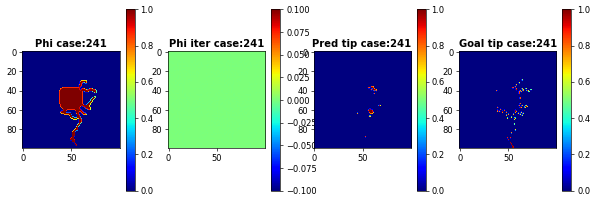

Plotting and Saving figures ...:  10%|█         | 1/10 [00:00<00:05,  1.68it/s]

Random case: 278


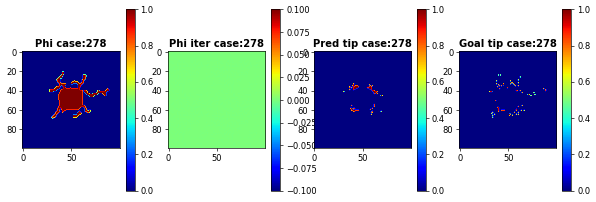

Plotting and Saving figures ...:  20%|██        | 2/10 [00:00<00:03,  2.33it/s]

Random case: 547


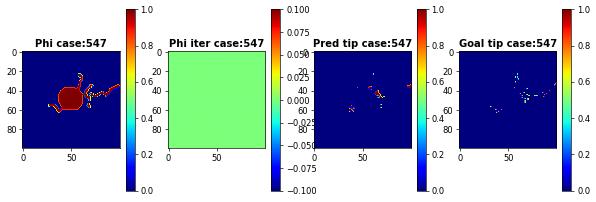

Plotting and Saving figures ...:  30%|███       | 3/10 [00:01<00:02,  2.65it/s]

Random case: 257


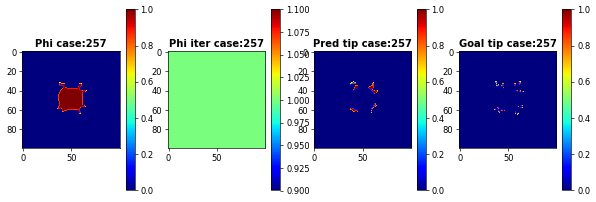

Plotting and Saving figures ...:  40%|████      | 4/10 [00:01<00:02,  2.84it/s]

Random case: 921


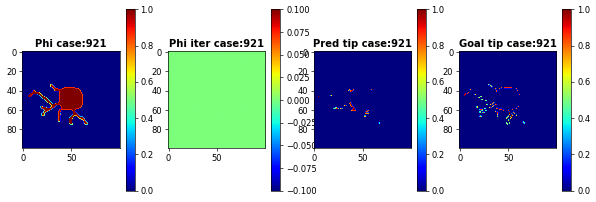

Plotting and Saving figures ...:  50%|█████     | 5/10 [00:01<00:01,  2.96it/s]

Random case: 506


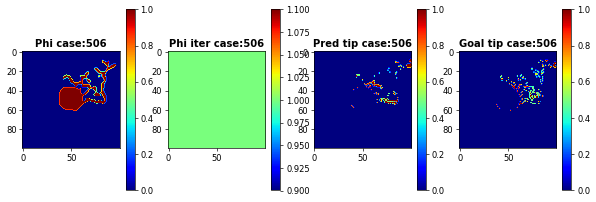

Plotting and Saving figures ...:  60%|██████    | 6/10 [00:02<00:01,  3.05it/s]

Random case: 268


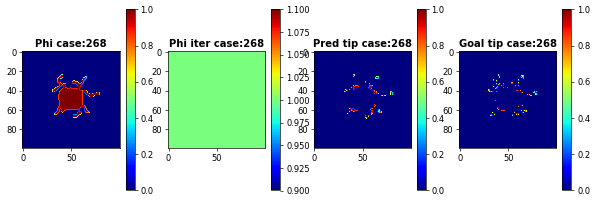

Plotting and Saving figures ...:  70%|███████   | 7/10 [00:02<00:01,  2.76it/s]

Random case: 1417


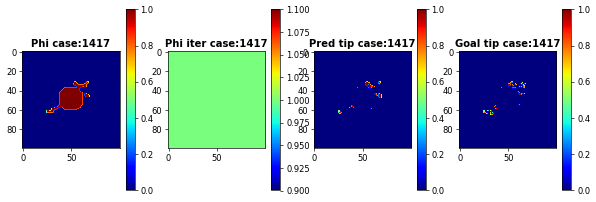

Plotting and Saving figures ...:  80%|████████  | 8/10 [00:02<00:00,  2.90it/s]

Random case: 863


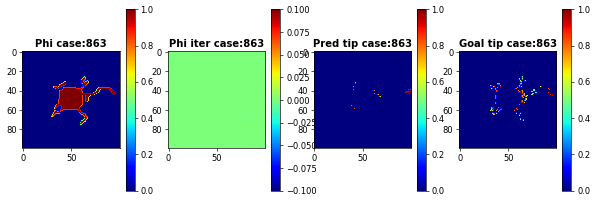

Plotting and Saving figures ...:  90%|█████████ | 9/10 [00:03<00:00,  3.01it/s]

Random case: 1227


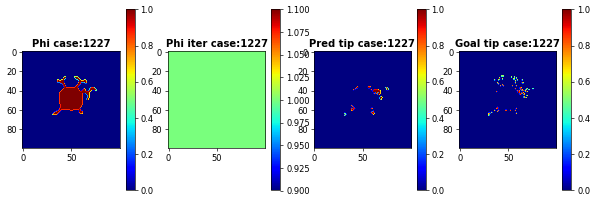

Plotting and Saving figures ...: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


In [6]:
from tqdm import tqdm
import copy

def push(input, cutoff):
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>cutoff*max_input] = 1
    output[input<=cutoff*max_input] = 0
    return output

for i in tqdm(range(10), desc="Plotting and Saving figures ..."):
    rand_case = np.random.randint((len(x_val_pred_phi)))
    print(f"Random case: {rand_case}")

    x_in = np.expand_dims(x_val_pred_phi[rand_case,...],axis=0)
    y_goal = np.expand_dims(y_val_tips[rand_case,...],axis=0)
    
    # prediction
    new_prediction = model.predict(x_in,verbose="0")
    tips = push(new_prediction[0,:,:,0],0.5)

    # plot prediction
    plt.figure(figsize=(12, 4), dpi=60)
    plt.gcf().set_facecolor("white")
    plt.subplot(1,4,1)
    plt.imshow(x_in[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Phi case:{rand_case}", fontweight='bold')
    plt.subplot(1,4,2)
    plt.imshow(x_in[0,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Phi iter case:{rand_case}", fontweight='bold')
    plt.subplot(1,4,3)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred tip case:{rand_case}", fontweight='bold')
    plt.subplot(1,4,4)
    plt.imshow(y_goal[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Goal tip case:{rand_case}", fontweight='bold')

    plt.show()